# Analysis 1 (Heptathalon)

* Be able to perform principcal component analysis (PCA) and exploratory factor analysis (EFA).
* Be able to apply manifold learning methods, including multidimensional scaling (MDS)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")  # make figures fit
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
import sklearn as sk
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.manifold as skm
import sklearn.preprocessing as skp

# make the Pandas tables a little more readable

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# Load the Data


In [6]:
df_hept = pd.read_csv('data/heptathlon.csv')
df_hept = df_hept.set_index('Athlete')
df_hept.head()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m,Score
Athlete,,,,,,,,
Joyner-Kersee (USA),12.69,1.86,15.80,22.56,7.27,45.66,128.51,7291
John (GDR),12.85,1.80,16.23,23.65,6.71,42.56,126.12,6897
Behmer (GDR),13.20,1.83,14.20,23.10,6.68,44.54,124.20,6858
Sablovskaite (URS),13.61,1.80,15.23,23.92,6.25,42.78,132.24,6540
Choubenkova (URS),13.51,1.74,14.76,23.93,6.32,47.46,127.90,6540


In [7]:
# Let's print out summary information to check the data quality 
# and structure.
df_hept.describe()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m,Score
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,13.840000,1.782000,13.117600,24.649200,6.152400,41.482400,136.054000,6090.600000
std,0.736648,0.077942,1.491884,0.969557,0.474212,3.545656,8.291088,568.469729
min,12.690000,1.500000,10.000000,22.560000,4.880000,35.680000,124.200000,4566.000000
25%,13.470000,1.770000,12.320000,23.920000,6.050000,39.060000,132.240000,5746.000000
50%,13.750000,1.800000,12.880000,24.830000,6.250000,40.280000,134.740000,6137.000000
75%,14.070000,1.830000,14.200000,25.230000,6.370000,44.540000,138.480000,6351.000000
max,16.420000,1.860000,16.230000,26.610000,7.270000,47.500000,163.430000,7291.000000


# Question: Should "score" be included in these analyses?

For now, let's omit the "score" column

In [8]:
df_hept.drop('Score',inplace=True, axis=1)

In [9]:
df_hept.describe()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,13.840000,1.782000,13.117600,24.649200,6.152400,41.482400,136.054000
std,0.736648,0.077942,1.491884,0.969557,0.474212,3.545656,8.291088
min,12.690000,1.500000,10.000000,22.560000,4.880000,35.680000,124.200000
25%,13.470000,1.770000,12.320000,23.920000,6.050000,39.060000,132.240000
50%,13.750000,1.800000,12.880000,24.830000,6.250000,40.280000,134.740000
75%,14.070000,1.830000,14.200000,25.230000,6.370000,44.540000,138.480000
max,16.420000,1.860000,16.230000,26.610000,7.270000,47.500000,163.430000


## 2.1 Rescaling the Data
Let us normalize the data by computing the "[z-scores](https://en.wikipedia.org/wiki/Standard_score#Calculation_from_raw_score)" of the values. This step of normalization (rescaling) is important to PCA.

Given a column x, the z-scores of the elements in x is simply

    (x - mean(x)) / std(x)
    
where, `std` means standard deviation.

In [10]:
# copy the form
df_hept_norm = df_hept.copy()
# scale as type float
df_hept_norm.ix[:,:7] = skp.scale(df_hept_norm.ix[:,:7].astype(np.float))
df_hept_norm

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m
Athlete,,,,,,,
Joyner-Kersee (USA),-1.593317,1.021376,1.835071,-2.199232,2.405348,1.202526,-0.928655
John (GDR),-1.371639,0.235702,2.129240,-1.051825,1.200091,0.310188,-1.222861
Behmer (GDR),-0.886716,0.628539,0.740486,-1.630792,1.135524,0.880133,-1.459210
Sablovskaite (URS),-0.318663,0.235702,1.445125,-0.767605,0.210059,0.373515,-0.469498
Choubenkova (URS),-0.457213,-0.549972,1.123591,-0.757078,0.360716,1.720658,-1.003745
Schulz (GDR),-0.124694,0.628539,0.261606,0.000842,0.382239,0.385030,-1.263483
Fleming (AUS),-0.637327,0.235702,-0.162546,-1.114985,0.468328,-0.346112,-0.432568
Greiner (USA),-0.401793,0.235702,0.692598,-0.178111,0.683553,-1.002412,-0.295929
Lajbnerova (CZE),-0.290954,0.628539,0.795215,0.221902,-0.091255,0.206562,-0.000492


In [7]:
# confirm the mean/std are 0/1
df_hept_norm.describe()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m
count,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,25.000000
mean,2.131628e-16,3.055334e-15,3.463896e-16,-4.352074e-16,-2.486900e-16,-1.589839e-15,0.000000
std,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00,1.020621e+00,1.020621
min,-1.593317e+00,-3.692669e+00,-2.132797e+00,-2.199232e+00,-2.738515e+00,-1.670227e+00,-1.459210
25%,-5.126326e-01,-1.571348e-01,-5.456503e-01,-7.676047e-01,-2.203898e-01,-6.972903e-01,-0.469498
50%,-1.246944e-01,2.357023e-01,-1.625458e-01,1.903222e-01,2.100590e-01,-3.461121e-01,-0.161751
75%,3.186635e-01,6.285394e-01,7.404863e-01,6.113890e-01,4.683283e-01,8.801333e-01,0.298637
max,3.574573e+00,1.021376e+00,2.129240e+00,2.064069e+00,2.405348e+00,1.732172e+00,3.369945


# 1. Multidimensional Scaling (MDS)
MDS seeks a low-dimensional representation of the data that preserves the distances in the high-dimensional space. It can take any kind of distance matrix as input.

Note that each time you run MDS, you will get a different result, unless `random_state` is fixed.

In [11]:
X[0:5]

array([[ 4.54076475e+00,  5.47619082e-01],
       [ 3.15808708e+00,  1.15789242e+00],
       [ 2.99527295e+00, -2.90098959e-03],
       [ 1.82401805e+00, -5.09606264e-02],
       [ 2.30903972e+00, -1.35487633e+00]])

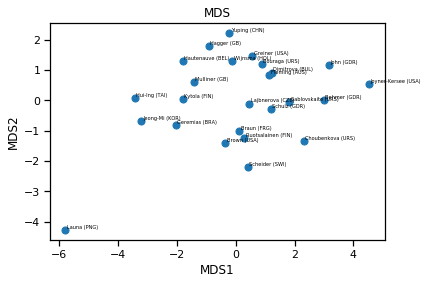

In [9]:
# Use MDS to visualize brands.
# Recall that df_bybrand is the mean-metric-by-brand 
# we created above.
X = skm.MDS(n_components=2).fit_transform(df_hept_norm)
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

for i, s in enumerate(df_hept_norm.index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=5)

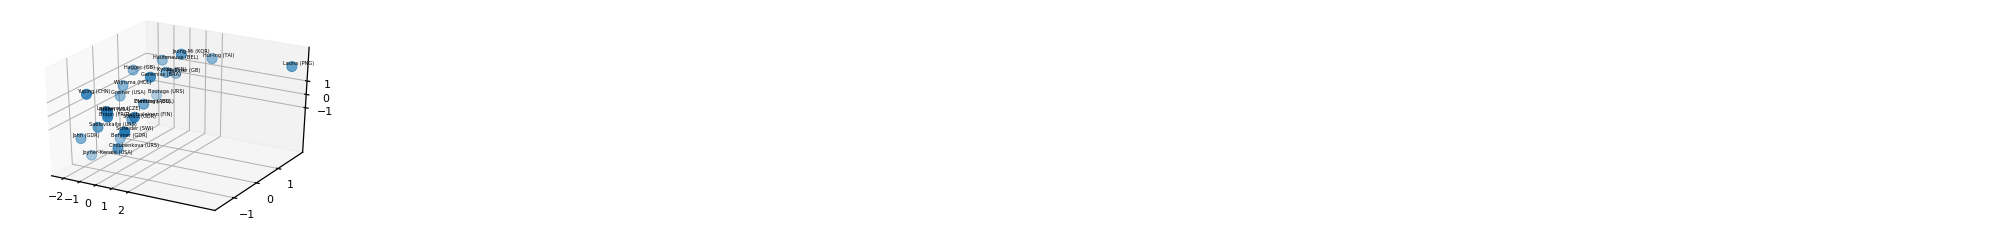

In [12]:
# We can also create 3d scatterplots.
X = skm.MDS(n_components=3).fit_transform(df_hept_norm)

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=100)

ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-1,0,1])
ax.set_zticks([-1,0,1])

for i, s in enumerate(df_hept_norm.index):
    x, y, _ = proj3d.proj_transform(X[i,0],X[i,1],X[i,2],
                                    ax.get_proj())
    plt.annotate(s, xy=(x-0.005,y+0.002), fontsize=5)

# 2. Bivariate Analysis (Quick Review)


## 2.2 Bivariate Analysis
For initial inspection of bivariate relationships among the variables, let us create a correlation plot.

In [13]:
# test for correlations
df_hept_norm.corr()

,Hurdles,HighJump,Shot,Run200m,LongJump,Javelin,Run800m
Hurdles,1.000000,-0.811403,-0.651335,0.773721,-0.912134,-0.007763,0.779257
HighJump,-0.811403,1.000000,0.440786,-0.487664,0.782442,0.002153,-0.591163
Shot,-0.651335,0.440786,1.000000,-0.682670,0.743073,0.268989,-0.419620
Run200m,0.773721,-0.487664,-0.682670,1.000000,-0.817205,-0.333043,0.616810
LongJump,-0.912134,0.782442,0.743073,-0.817205,1.000000,0.067108,-0.699511
Javelin,-0.007763,0.002153,0.268989,-0.333043,0.067108,1.000000,0.020049
Run800m,0.779257,-0.591163,-0.419620,0.616810,-0.699511,0.020049,1.000000


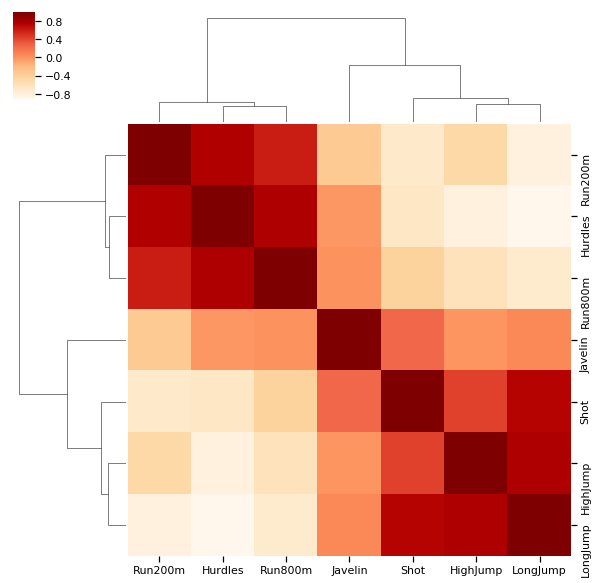

In [14]:
# draw a "clustered" heatmap
sns.clustermap(df_hept_norm.corr(),cmap=plt.cm.OrRd)

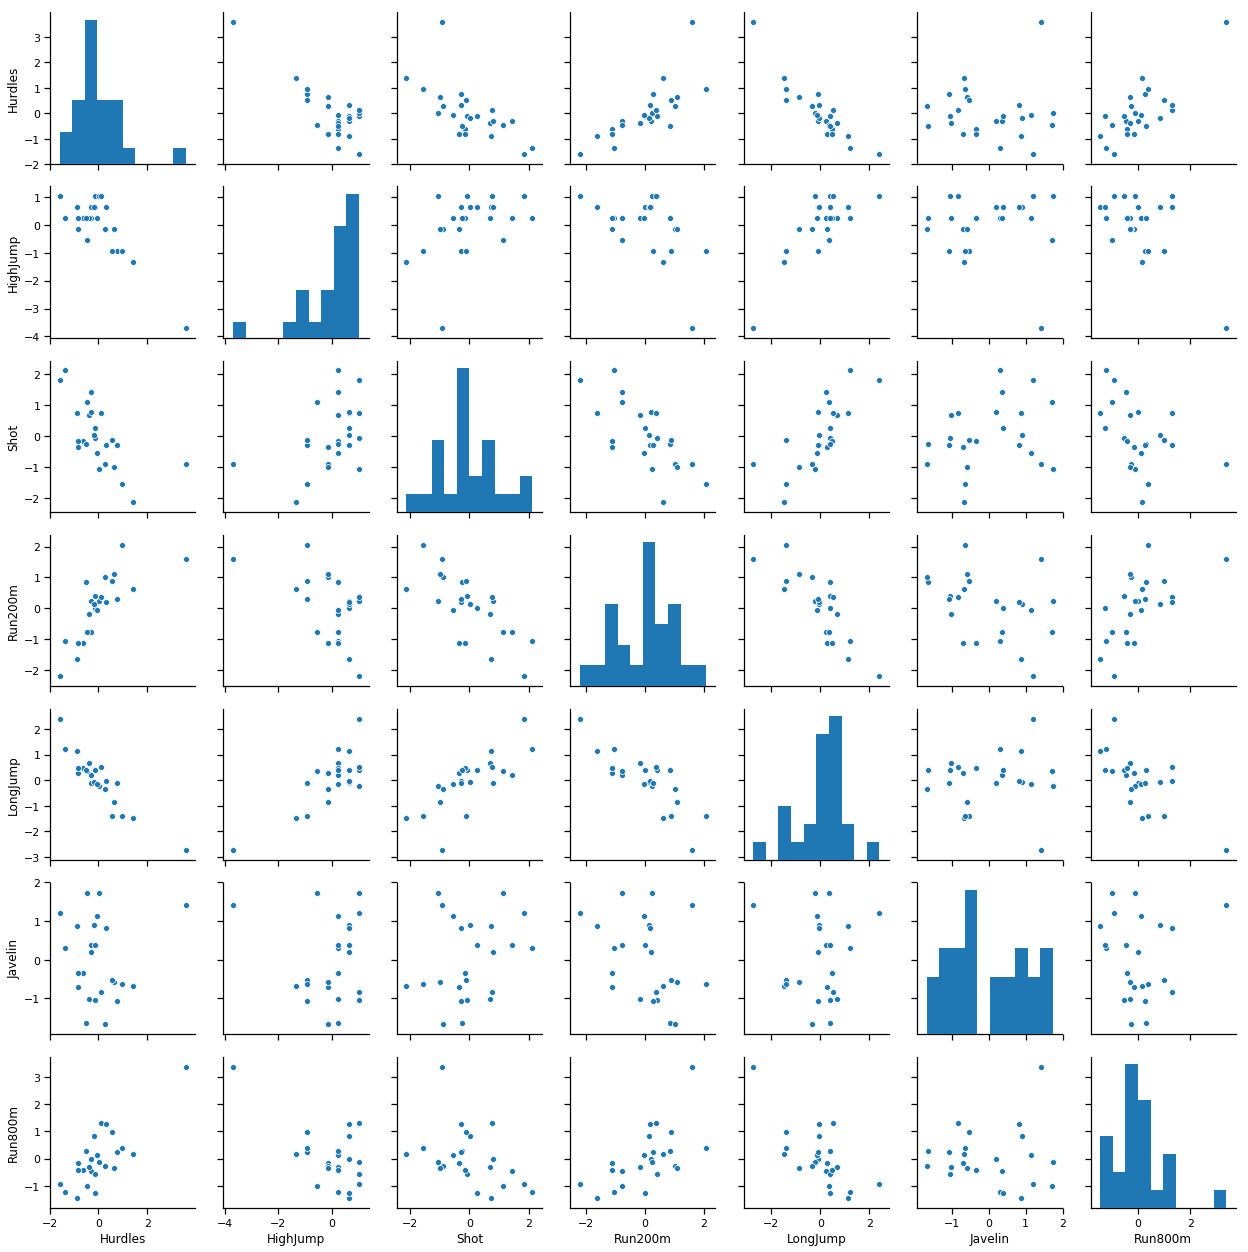

In [15]:
# pairplot
sns.pairplot(df_hept_norm)

# 2. Principal Component Analysis

We have demonstrated how to use principal component analysis (PCA) to do dimensionality reduction for visualization in the previous lab. Now let us look at PCA in greater details.

#### Some notes:
* PCA finds the unique model line that minimizes error orthogonal (perpendicular) to the model line.
* The second principal component (yellow) captures the next highest orthogonal direction of variance. PCA attempts to find the next PC that is uncorrelated with previous PCs.
* Normalization is important! Clean it up!
* Typical steps to follow for PCA:
* Mean subtraction (a.k.a. "mean centering")
• Ensures that the first principal component describes the direction of maximum variance
• Subtract mean from every point
* Variable scaling -- Divide each variable by its standard deviation
* Do both “z-score”

#### PCA choose criteria:
* In PCA there are three common criteria of Component selection, which you can choose base on them. But after choosing, Some may delete in next step. The criteria are:
* 1- eigenvalue one criterion: based on this criterion you choose the first components with eigenvalues higher than 1.
* 2- Amount of explained variance: based on this, the chosen factors should explain 70 to 80% of your variance at least.
* 3- Scree plot: this is a graphical method in which you choose the factors until a break in the graph.

In [12]:
# Create a PCA model
pca_model = skd.PCA().fit(df_hept_norm.ix[:,:7])

In [13]:
# There are 7 components extracted from the data; each component is
# a 7-dimensional vector.
pca_model.components_.shape

(7, 7)

In [14]:
# Look at the variances explained by each component.
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([4.64611996, 1.24408391, 0.54272305, 0.47621544, 0.25548619,
       0.0759954 , 0.05104272])

One way of determining the number of principal components to retain is to look at the explained variance as shown above, and drop those principal components whose explained variance is smaller than 1.

Another way is to create a __Scree Plot__ as below, and find the "elbow" point on the plotted curve.

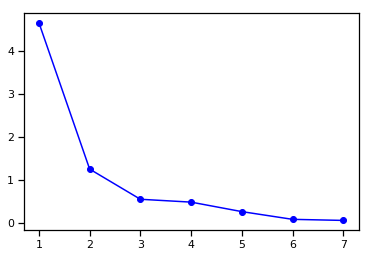

In [15]:
# A "scree" plot.
plt.plot(range(1,8),pca_model.explained_variance_,'b-o')

Next we will create a __biplot__, which is 2-D scatterplot showing all the data points as well as the data variables in the space defined by the first two principal components.

[0.45287105 0.15792058]
[-0.37719923 -0.24807386]
[-0.3630725   0.28940743]
[ 0.40789504 -0.26038545]
[-0.45623185 -0.05587394]
[-0.075409    0.84169212]
[0.37495938 0.22448984]


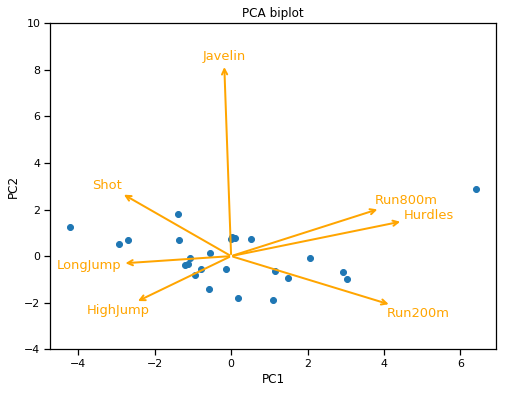

In [16]:
# Scatterplot of disaggregated data
X = pca_model.transform(df_hept_norm.ix[:,:7])
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-4, 10)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    print(v[:2])
    plt.annotate(df_hept_norm.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))

### Q1: What's the correlation between PC1 and *Score* from the original data?

In [40]:
### YOUR CODE HERE ###
df_hept_reload = pd.read_csv('data/heptathlon.csv')
df_hept_score = df_hept_reload['Score']
df_hept_score = skp.scale(df_hept_score.astype(np.float))

import numpy as np
print("the correlation between PC1 and Score is: ", np.corrcoef(X[:,0], df_hept_score)[0, 1])

the correlation between PC1 and Score is:  -0.9910977748389508


# 3. Factor Analysis

We didn't cover factor analysis in class but it is in the readings. Factor analysis is similar to PCA but we have a little bit more control over the factors and how they relate to each other.

Below, we'll create 3 factors for the events and then print out their loadings.  That tells us how much each event contributs to each factor.

In [21]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=3) \
              .fit(df_hept_norm.ix[:,:7])

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:3,:].T, 
                   index=df_hept.columns,
                   columns=['Factor1', 'Factor2', 'Factor3'])
df_loadings

,Factor1,Factor2,Factor3
Hurdles,0.951275,0.187302,0.109397
HighJump,-0.763002,-0.446091,0.050968
Shot,-0.732991,0.160497,0.303633
Run200m,0.885045,-0.403132,0.056832
LongJump,-0.964212,-0.076056,0.140774
Javelin,-0.129255,0.511201,0.092702
Run800m,0.750836,0.151658,0.308775


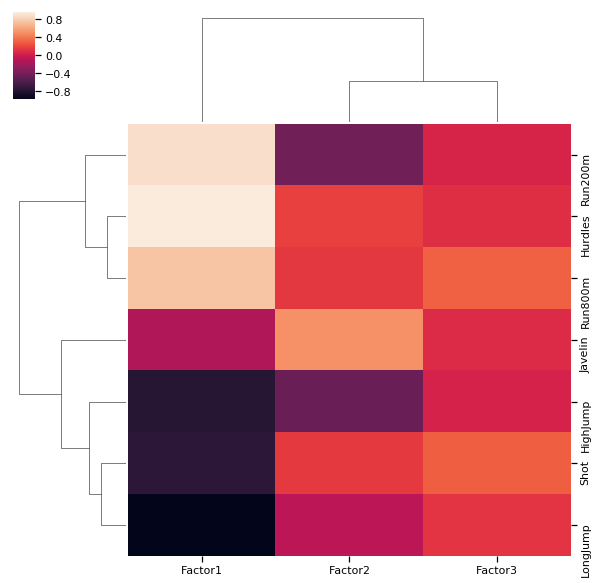

In [22]:
# Visualize the factor loading matrix
sns.clustermap(df_loadings)

If you read down Factor 1 you can see that Hurdles, Run200m and Run800m seem to have high loadings.  We might name this the "running" factor.  Factor 3 has relatively high values for the jumping events.  Factor 2 is a bit of a mishmash.  We see high values for shot and javelin, which makes sense, but also for Run800m.  We might not have a great story for this.  Given our experience with PCA above we might try a two factor model instead.

In [24]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=2) \
              .fit(df_hept_norm.ix[:,:7])

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:2,:].T, 
                   index=df_hept.columns,
                   columns=['Factor1', 'Factor2'])
df_loadings

,Factor1,Factor2
Hurdles,0.956422,0.173830
HighJump,-0.769389,-0.433264
Shot,-0.721458,0.186360
Run200m,0.877247,-0.401455
LongJump,-0.953748,-0.051143
Javelin,-0.126044,0.508433
Run800m,0.756286,0.140128


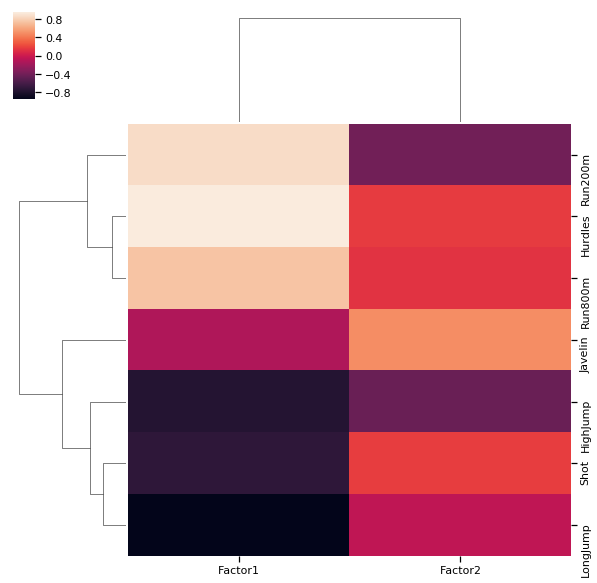

In [25]:
# Visualize the factor loading matrix
sns.clustermap(df_loadings)

# Analysis 2 (Products)





In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")  # make figures fit
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
import sklearn as sk
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.manifold as skm
import sklearn.preprocessing as skp

# make the Pandas tables a little more readable

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# 1. Bivariate Analysis (Quick Review)

In this lab, we will mostly follow the analytic procedure in the following book chapter:

> Chapman and Feit, "Reducing Data Complexity", _R for Marketing Research and Analytics_, Chapter 8, (2015).

Many of the text descriptions below are taken from this chapter. Of course, you will see example code given in python instead of R. We will use the dataset in the book, customer brand perception surveys. For exercise questions, you will work on the iris dataset.

This section involves data importing and some descriptive analysis, serving as a quick review of previous weeks.

In [62]:
# Loads dataframe from a remote URL
df_survey = pd.read_csv('data/products.csv')
df_survey.head()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy,brand
0,2,4,8,8,2,9,7,4,6,a
1,1,1,4,7,1,1,1,2,2,a
2,2,3,5,9,2,9,5,1,6,a
3,1,6,10,8,3,4,5,2,1,a
4,1,1,5,8,1,9,9,1,1,a


In [63]:
# Let's print out summary information to check the data quality 
# and structure.
df_survey.describe()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,4.488000,4.417000,6.195000,6.06800,4.323000,4.259000,4.33700,5.220000,3.727000
std,3.203454,2.608432,3.078059,2.74425,2.778199,2.667027,2.39858,2.742101,2.544592
min,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000
25%,1.000000,2.000000,4.000000,4.00000,2.000000,2.000000,2.00000,3.000000,1.000000
50%,4.000000,4.000000,7.000000,6.00000,4.000000,4.000000,4.00000,5.000000,3.000000
75%,7.000000,6.000000,9.000000,8.00000,6.000000,6.000000,6.00000,7.000000,5.000000
max,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.00000,10.000000,10.000000


In [64]:
# Let's check how many records we have per brand.
df_survey.brand.value_counts()

g    100
b    100
d    100
e    100
f    100
i    100
j    100
c    100
h    100
a    100
Name: brand, dtype: int64

Based on the above summary information, we can tell that the data are clean and are formatted appropriately.

## 1.2 Rescaling the Data
Let us normalize the data by computing the "[z-scores](https://en.wikipedia.org/wiki/Standard_score#Calculation_from_raw_score)" of the values. This step of normalization (rescaling) is important to PCA.

Given a column x, the z-scores of the elements in x is simply

    (x - mean(x)) / std(x)
    
where, `std` means standard deviation.

### Q2. Rescale the data

In [71]:
df_survey_norm = df_survey.copy()
# scale as type float
df_survey_norm.ix[:,:9] = skp.scale(df_survey_norm.ix[:,:9].astype(np.float))
df_survey_norm.head()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy,brand
0,-0.77705,-0.159946,0.586702,0.704370,-0.836572,1.778524,1.110796,-0.445137,0.893714,a
1,-1.08937,-1.310638,-0.713468,0.339789,-1.196697,-1.222571,-1.391936,-1.174870,-0.679034,a
2,-0.77705,-0.543510,-0.388426,1.068950,-0.836572,1.778524,0.276552,-1.539736,0.893714,a
3,-1.08937,0.607182,1.236787,0.704370,-0.476446,-0.097160,0.276552,-1.174870,-1.072221,a
4,-1.08937,-1.310638,-0.388426,0.704370,-1.196697,1.778524,1.945040,-1.539736,-1.072221,a


After rescaling (normalization), the means of all columns are all technically 0, and standard deviation 1.0.

## 1.3 Bivariate Analysis
For initial inspection of bivariate relationships among the variables, let us create a correlation plot.

### Q3. Create a clustermap. What do you see?
- Can you identify the clusters of variables from the plot?

In [72]:
df_survey_norm.drop('brand',inplace=True, axis=1)

In [73]:
df_survey_norm.head()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy
0,-0.77705,-0.159946,0.586702,0.704370,-0.836572,1.778524,1.110796,-0.445137,0.893714
1,-1.08937,-1.310638,-0.713468,0.339789,-1.196697,-1.222571,-1.391936,-1.174870,-0.679034
2,-0.77705,-0.543510,-0.388426,1.068950,-0.836572,1.778524,0.276552,-1.539736,0.893714
3,-1.08937,0.607182,1.236787,0.704370,-0.476446,-0.097160,0.276552,-1.174870,-1.072221
4,-1.08937,-1.310638,-0.388426,0.704370,-1.196697,1.778524,1.945040,-1.539736,-1.072221


In [74]:
df_survey_norm.corr()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy
perform,1.000000,0.500202,-0.122446,-0.256332,0.359172,0.057129,0.101946,0.008733,0.306659
leader,0.500202,1.000000,0.026890,-0.290358,0.571215,0.033094,0.118310,0.066512,0.208700
latest,-0.122446,0.026890,1.000000,0.245154,0.009952,-0.254419,-0.342714,0.627628,-0.397180
fun,-0.256332,-0.290358,0.245154,1.000000,-0.281097,-0.066553,-0.145218,0.127974,-0.237161
serious,0.359172,0.571215,0.009952,-0.281097,1.000000,-0.002656,0.023757,0.121009,0.180703
bargain,0.057129,0.033094,-0.254419,-0.066553,-0.002656,1.000000,0.739627,-0.350534,0.467381
value,0.101946,0.118310,-0.342714,-0.145218,0.023757,0.739627,1.000000,-0.434535,0.505962
trendy,0.008733,0.066512,0.627628,0.127974,0.121009,-0.350534,-0.434535,1.000000,-0.298246
rebuy,0.306659,0.208700,-0.397180,-0.237161,0.180703,0.467381,0.505962,-0.298246,1.000000


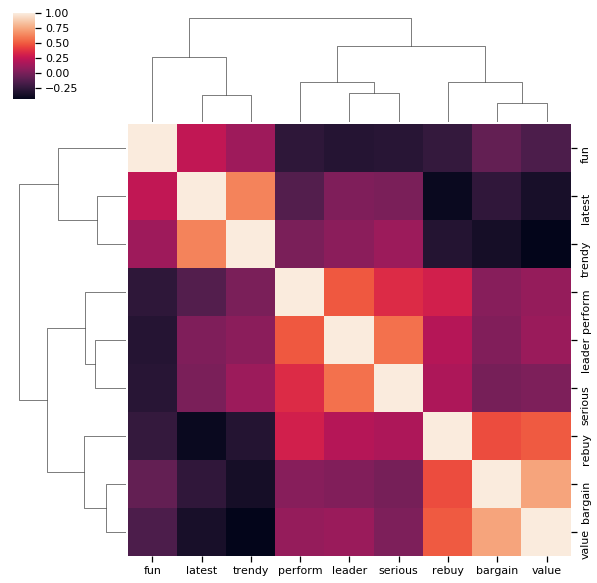

In [76]:
# Visualize the factor loading matrix
sns.clustermap(df_survey_norm.corr())

#### Comment:
* The correlation matrix and clustermap have been shown above. According to the clustermap, it can be found that "rebuy", "bargain" and "value" are closely correlated. And "perform", "leader" and "serious" are closely correlated as well. Thus it seems that all these attributes can be divided into at least two groups.

## By-Brand Analysis
We are going combine all products from one manufacturer into a row (based on the mean score)

In [78]:
df_survey_norm = df_survey.copy()
# scale as type float
df_survey_norm.ix[:,:9] = skp.scale(df_survey_norm.ix[:,:9].astype(np.float))
df_bybrand = df_survey_norm.groupby('brand').mean()
df_bybrand.head()

,perform,leader,latest,fun,serious,bargain,value,trendy,rebuy
brand,,,,,,,,,
a,-0.886362,-0.528168,0.411179,0.656974,-0.919400,0.214203,0.184785,-0.525407,-0.596465
b,0.931336,1.071294,0.726470,-0.972701,1.183733,0.041640,0.151415,0.740679,0.237092
c,0.650249,1.163350,-0.102388,-0.845098,1.223346,-0.607347,-0.440898,0.025541,-0.132504
d,-0.680231,-0.593373,0.352671,0.186665,-0.692521,-0.881197,-0.933102,0.737030,-0.494236
e,-0.564673,0.192933,0.456685,0.296039,0.042135,0.551826,0.418373,0.138649,0.036566


We can see the correlations of the values across columns for `bargain/value/rebuy`, which is consistent with the correlation matrix visualization above. But it is better to formalize such kind of insights, and the remainder of this lab introduces how to do so.

# 2. Principal Component Analysis

We have demonstrated how to use principal component analysis (PCA) to do dimensionality reduction for visualization in the previous lab. Now let us look at PCA in greater details.

### Q4_a. Create a PCA model

In [79]:
# Create a PCA model, call it pca_model
### YOUR CODE HERE ###
# Create a PCA model
pca_model = skd.PCA().fit(df_survey_norm.ix[:,:9])

In [80]:
# Confirm that there are 9 components extracted from the data; each component is
# a 9-dimensional vector.
pca_model.components_.shape

(9, 9)

### Q4_b. Look at the variances explained by each component.

In [81]:
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([2.98227784, 2.09865033, 1.08033521, 0.72793893, 0.6381841 ,
       0.53537861, 0.39049493, 0.31235878, 0.24339028])

#### Comment:
* First we obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition. Then we choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace. Thus we can construct the projection matrix W from the selected k eigenvectors. Finally, we can transform the original dataset X via W to obtain a k-dimensional feature subspace Y.
* The explained variance can be calculated from the eigenvalues and it tells us how much information/variance can be attributed to each of the principle components.
* All these positive eigenvalues have been shown above.

One way of determining the number of principal components to retain is to look at the explained variance as shown above, and drop those principal components whose explained variance is smaller than 1.

Another way is to create a __Scree Plot__ as below, and find the "elbow" point on the plotted curve.

### Q5. Generate a scree plot

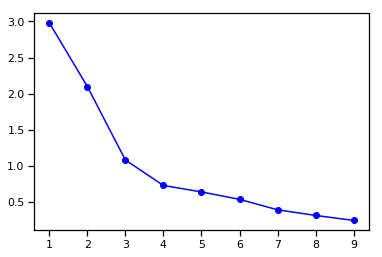

In [82]:
# A "scree" plot.
plt.plot(range(1,10),pca_model.explained_variance_,'b-o')

#### Comment:
* The scree plot has been shown above. And we want to find those principal components whose explained variance is larger than 1. Thus we keep 3 principal components here.

## How many components do you think we should keep?

Next we will create a __biplot__, which is 2-D scatterplot showing all the data points as well as the data variables in the space defined by the first two principal components.

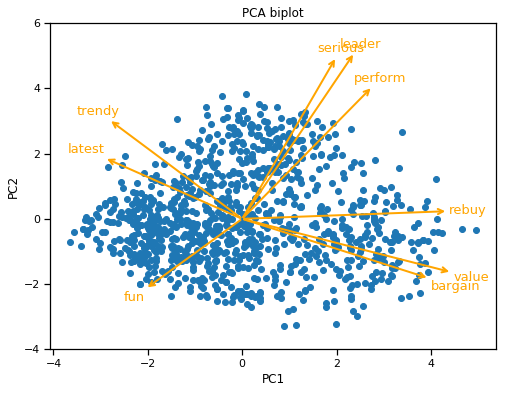

In [83]:
# Scatterplot of disaggregated data
X = pca_model.transform(df_survey_norm.ix[:,:9])
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-4, 6)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(df_survey_norm.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))

The above biplot shows not only all the data points, but also the original variable dimensions projected onto the 2-D space defined by the first two principal components.

To make the above biplot easier to interpret, we can show the aggregated data (by product) rather than individual data points.

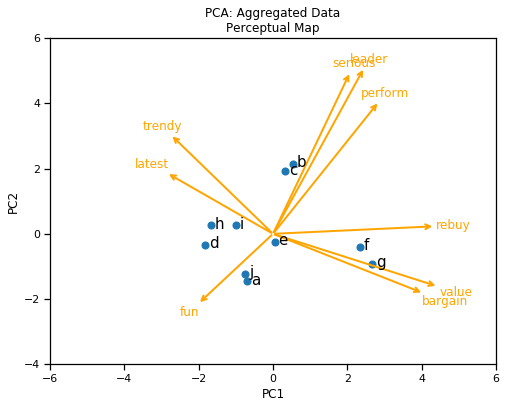

In [84]:
# Scatterplot of aggregated data
X = pca_model.transform(df_bybrand)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Aggregated Data\nPerceptual Map')
plt.xlim(-6,6)
plt.ylim(-4,6)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(df_survey_norm.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=12, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, 
                    color='orange'))

# Add data point annotation
for i, s in enumerate(df_bybrand.index):
    plt.annotate(s, xy=X[i,:2]+[0.1,-0.1], fontsize=15)

The above plot is much more interpretable compared with the previous one. It is called a _perceptual map_, showing where the brands are placed with respect to the first two principal components. 

See the referred book (by Chapman and Feit) pages 206-209 for instructions on how to interpret this plot. Pay special attention to pages 208-209 in the book where it discusses __caveats of perceptual map interpretation__.

# 3. Exploratory Factor Analysis

Exploratory Factor Analysis (EFA) can produce similar results to PCA, but is conceptually different. Refer to the lecture and reading materials for more details.

We will introduce very simple EFA examples below.

In [85]:
# build a 2-factor model
fa_model = skd.FactorAnalysis(n_components=2).fit(df_survey_norm.ix[:,:9])

# Show the loadings
pd.DataFrame(fa_model.components_[:2,:].T, 
             index=df_bybrand.columns,
             columns=['Factor1', 'Factor2'])

,Factor1,Factor2
perform,0.235994,0.556420
leader,0.238080,0.780335
latest,-0.441472,0.101670
fun,-0.241319,-0.327027
serious,0.141222,0.674193
bargain,0.780184,-0.194738
value,0.867785,-0.138932
trendy,-0.488965,0.232029
rebuy,0.633149,0.126516


Compare the factors with the principal components. Can you find the similarity between the results?

In [86]:
# build a PCA model to compare with the factor model above
pca_model = skd.PCA(n_components=2).fit(df_survey_norm.ix[:,:9])

# Show the principcal components
pd.DataFrame(pca_model.components_[:2,:].T, 
             index=df_bybrand.columns,
             columns=['PC1', 'PC2'])

,PC1,PC2
perform,0.237468,0.419912
leader,0.205826,0.523819
latest,-0.370381,0.201453
fun,-0.251060,-0.250380
serious,0.159740,0.510473
bargain,0.399173,-0.218497
value,0.447456,-0.189808
trendy,-0.351029,0.318490
rebuy,0.439018,0.015098


In [87]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=3) \
              .fit(df_survey_norm.ix[:,:9])

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:3,:].T, 
                   index=df_bybrand.columns,
                   columns=['Factor1', 'Factor2', 'Factor3'])
df_loadings

,Factor1,Factor2,Factor3
perform,0.170643,-0.236606,0.541128
leader,0.061587,-0.424637,0.697429
latest,-0.858825,-0.377155,-0.118785
fun,-0.269700,0.076980,-0.366896
serious,0.027767,-0.295387,0.617974
bargain,0.572699,-0.534012,-0.312095
value,0.668141,-0.535555,-0.231923
trendy,-0.687795,-0.129406,0.122562
rebuy,0.572353,-0.296603,0.120207


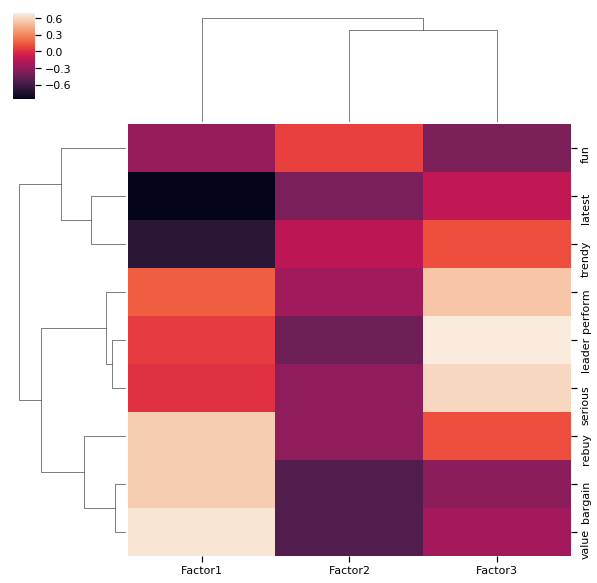

In [88]:
# Visualize the factor loading matrix
sns.clustermap(df_loadings)

### Q6. Can you describe the factors?

#### Comment:
* Here we use both 2 and 3 factors to carry Factor Analysis. As we can see in the 3-factor analysis clustermap, Factor 1 has strong correlation with "value", "bargain" and "rebuy". And Factor 2 has strong correlation with "serious", "leader" and "perform". Since these two groups can be explained quite well by Factor 1 and Factor 2, they should also be quite similar to each other. This feature can also be noticed in the previous PCA result.

* The 2-dimension PCA and 2-factor analysis results shown above are quite similar to each other. Thus we can give the comparison between PCA and EFA. 
* Principal component analysis involves extracting linear composites of observed variables. We need to find new features which are the principal components of the data set. These features are the projections onto the principal component axes, which are lines that minimize the average squared distance to each point in the data set. To ensure uniqueness, all of the principal component axes must be orthogonal.
* Factor analysis is based on a formal model predicting observed variables from theoretical latent factors. Briefly stated, using PCA you are expressing each component (factor) as a linear combination of the variables, whereas in FA these are the variables that are expressed as linear combinations of the factors.

There are a number of important concepts within factor analysis that are not covered here, including:
- _simple structure_ of factors
  - [reference](http://www.ats.ucla.edu/stat/spss/output/factor1.htm)
  - [reference](https://en.wikipedia.org/wiki/Factor_analysis#Rotation_methods)
- rotation (varimax, promax, ...)
  - [strategy for selecting a rotation](http://jalt.org/test/PDF/Brown31.pdf)
- orthogonal and oblique factors
- determining the number of components in EFA
- confirmatory factor analysis (CFA)

# 4. Manifold Learning

So far the dimensionality reduction methods we have studied are linear in nature. If the actual data points are distributed on a low-dimensional non-linear manifold living in a high-dimensional space, then linear methods will most likely fail to reveal the most intuitive structures of the data. This means we will see "a mess" in our low-dimensional visualization while the actual data actually has a very simple and elegant non-linear (e.g., curved) structure. 

In such situations where linear models face troubles, we can use manifold learning to do non-linear dimensionality reduction. 


## 4.1 Multidimensional Scaling (MDS)
MDS seeks a low-dimensional representation of the data that preserves the distances in the high-dimensional space. It can take any kind of distance matrix as input.

Note that each time you run MDS, you will get a different result, unless `random_state` is fixed.

### Q7. Create a MDS representation

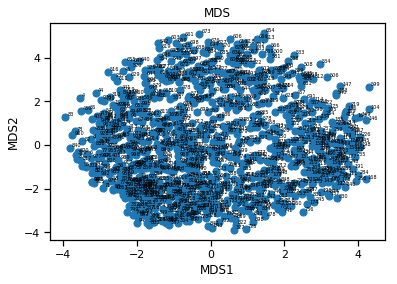

In [105]:
# Use MDS to visualize *brands*.
# Recall that df_bybrand is the mean-metric-by-brand 
# we created above.
X = skm.MDS(n_components=2).fit_transform(df_survey_norm.ix[:,:9])
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

for i, s in enumerate(df_survey_norm.ix[:,:9].index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=5)

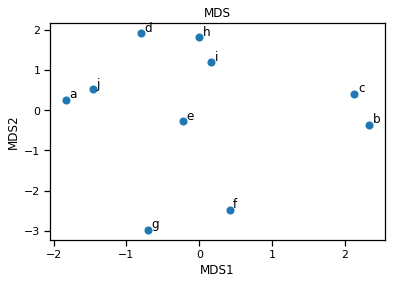

In [131]:
X = skm.MDS(n_components=2).fit_transform(df_bybrand)
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')

for i, s in enumerate(df_bybrand.index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=12)

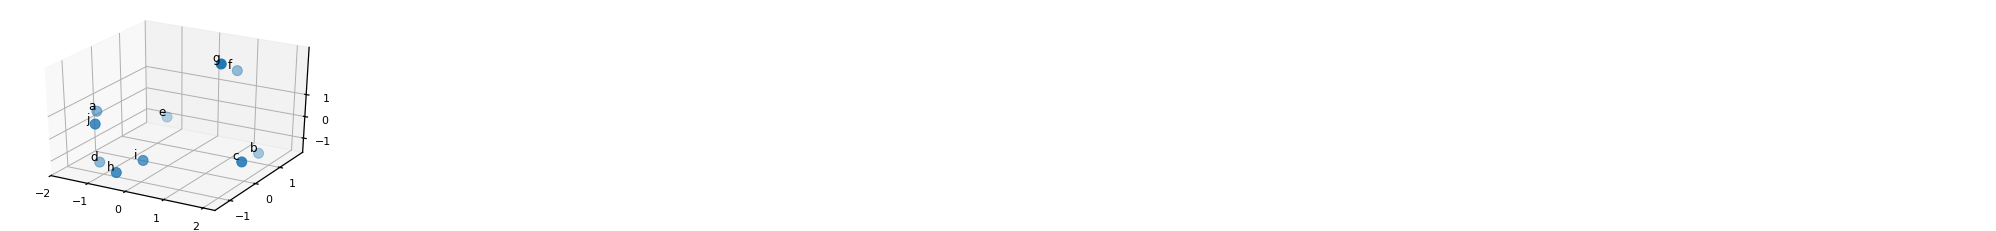

In [133]:
fig = plt.figure()
X = skm.MDS(n_components=3).fit_transform(df_bybrand)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=100)

ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-1,0,1])
ax.set_zticks([-1,0,1])

for i, s in enumerate(df_bybrand.index):
    x, y, _ = proj3d.proj_transform(X[i,0],X[i,1],X[i,2],
                                    ax.get_proj())
    plt.annotate(s, xy=(x-0.005,y+0.002), fontsize=12)

#### Comment:
* By using MDS, we can visualize the level of similarity of individual cases of our dataset. Here we use mean values of attributes within a brand as this brand's corresponding values and use MDS to explain. We place these brands samples in both 2-dimensional and 3-dimensional space such that the between-object distances are preserved as well as possible. Each object is then assigned coordinates in each of the dimensions. 
* Close samples have more similarities in the scatter plots above. It can be seen from both scatter plots that there are some clusters in the plots. To be more specific, brands 'd', 'h' and 'i' can be clustered into one group. Brands 'b' and 'c' can be clustered into one group. Brands 'f' and 'g' should also have much in common.

## 4.2  t-distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is not a new technique, but rather one that has recently come into
fashion, partly as a result of access to more powerful computing resources.
t-SNE is similar to MDS.  If you have time, repeat the work you did in exercise 4.1 using ```sklearn.manifold.TSNE``` instead of MDS.  Please see t-SNE documentation at http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


### Q8. Create a t-SNE representation

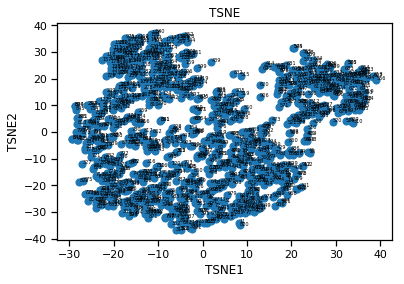

In [107]:
# Use t-SNE to visualize *brands*.
X = sk.manifold.TSNE(n_components=2).fit_transform(df_survey_norm.ix[:,:9])
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE')

for i, s in enumerate(df_survey_norm.ix[:,:9].index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=5)

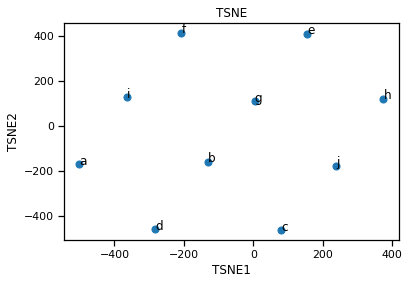

In [134]:
# Use t-SNE to visualize *brands*.
X = sk.manifold.TSNE(n_components=2).fit_transform(df_bybrand)
plt.scatter(X[:,0],X[:,1],s=50)

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE')

for i, s in enumerate(df_bybrand.index):
    plt.annotate(s, xy=X[i,:2]+0.05, fontsize=12)

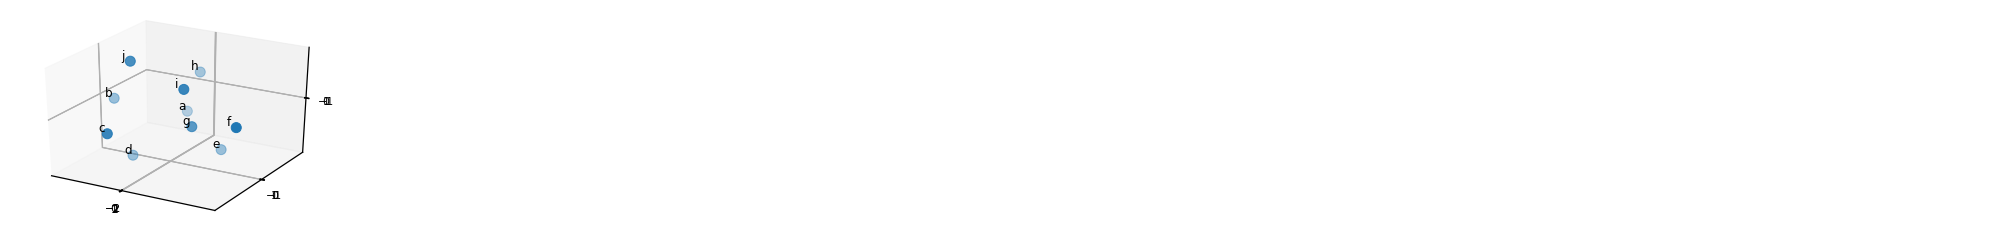

In [148]:
X = sk.manifold.TSNE(n_components=3).fit_transform(df_bybrand)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=100)

ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-1,0,1])
ax.set_zticks([-1,0,1])

for i, s in enumerate(df_bybrand.index):
    x, y, _ = proj3d.proj_transform(X[i,0],X[i,1],X[i,2],
                                    ax.get_proj())
    plt.annotate(s, xy=(x-0.005,y+0.002), fontsize=12)

#### Comment:
* Similarly, by using t-SNE (t-distributed Stochastic Neighbor Embedding), we can also visualize the level of similarity of individual cases of our dataset. Here t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.
* Here we use the same data set in previous MDS example. We place these brands samples in both 2-dimensional and 3-dimensional space such that the between-object distances are preserved as well as possible. Each object is then assigned coordinates in each of the dimensions. 
* Both 2-D plot and 3-D plot vary a lot each time. But the 2-D scatter plot indicates that there are not obvious clusters in these brands. In the 3-D plot shown above, brand 'g', 'a' and 'i' are close to each other. But this result may vary a lot next time.